# Installing and Reading in of packages

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q -U bitsandbytes
%pip install -q -U git+https://github.com/huggingface/transformers.git
%pip install -q -U git+https://github.com/huggingface/peft.git
%pip install -q -U git+https://github.com/huggingface/accelerate.git@fix-to-int8

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × git checkout -q fix-to-int8 did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      error: pathspec 'fix-to-int8' did not match any file(s) known to git
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q fix-to-int8 did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
import torch

from model_evaluation import get_model_evaluation
from model_extraction import get_model, get_tokenizer, get_pipeline
from model_training import train_model, train_lora_model

c:\Users\Owent\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Owent\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Owent\AppData\Local\Pro

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reading in of Data

In [6]:
data = pd.read_csv("data/dataset.csv", header = None, names = ["Label", "Text"])
data = data[['Text', 'Label']]

print(data.head()) # First column: 1 - positive, 0 - negative
print(data.shape)

                                                Text  Label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1
(10662, 2)


In [7]:
testing_data = pd.read_csv('data/testing_data.csv')

print(testing_data)

                                                   Text  Label
0     this bracingly truthful antidote to hollywood ...      1
1     once the downward spiral comes to pass , auto ...      1
2     bray is completely at sea ; with nothing but a...      0
3     while the production details are lavish , film...      0
4     anyone who suffers through this film deserves ...      0
...                                                 ...    ...
1595  a dream cast of solid female talent who build ...      1
1596  it's an unusual , thoughtful bio-drama with a ...      1
1597  a gorgeous , somnolent show that is splendidly...      0
1598  it's tough to be startled when you're almost d...      0
1599  george lucas returns as a visionary with a tal...      1

[1600 rows x 2 columns]


# Model (Pre-built on Hugging Face)
For a start, we will try a pre-built model on Hugging Face that will analyse the text and give us a rating on whether it is `POSITIVE` or `NEGATIVE`.

In [8]:
sentiment_pipeline = pipeline("sentiment-analysis", model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english", device = device)
output = sentiment_pipeline(list(testing_data["Text"]))

Device set to use cuda:0


In [9]:
model_predictions = pd.Series(map(lambda x: x['label'], output))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

## Model Evaluation
We will evaluate the model and look at the accuracy of the model.

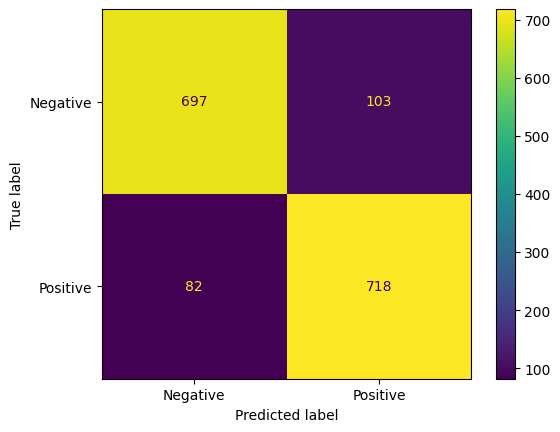

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88       800
    Positive       0.87      0.90      0.89       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Accuracy: 0.884375
Recall: 0.8975
Precision: 0.8745432399512789
F1-score: 0.8858729179518815


In [10]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)

# Custom Model
While we see that the pre-built model performs rather well (with an accuracy of around 88%), we will try to train a model on our own and fine-tune it based on the dataset provided. This would hopefully increase the accuracy of the model in determining the sentiment of the input text.

In [11]:
training_data = pd.read_csv('data/training_data.csv')
validation_data = pd.read_csv('data/validation_data.csv')
training_model_dir = "google-bert/bert-large-uncased"
# training_model_dir = "google-bert/bert-base-uncased"
# training_model_dir = "distilbert/distilbert-base-uncased"
num_epochs = 20
num_labels = 2 # Only 2 labels - Positive or Negative
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
train_lora_model(training_data=training_data, 
            validation_data=validation_data, 
            model_dir=training_model_dir,
            num_epochs=num_epochs,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id
            )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Owent\Desktop\Projects\personal\projects\Sentence Sentiment Analysis\model_training.py:123: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.351500,0.353753,0.879100,0.879100,0.879101,0.879101


In [15]:
model_dir = 'google-bert/bert-large-uncased'
model_name = model_dir.split('/')[1]
num_epochs = 10
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = get_model(model_dir=model_dir, model_name=model_name, num_epochs=num_epochs, num_labels=num_labels, id2label=id2label, label2id=label2id, lora=True)
tokenizer = get_tokenizer(model_name)
pipeline = get_pipeline(model=model, tokenizer=tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [16]:
model_predictions = pd.Series(map(lambda x: x['label'], pipeline(list(testing_data['Text']))))

label_mapping = {"POSITIVE": 1, "NEGATIVE": 0}
model_predictions = model_predictions.map(label_mapping)

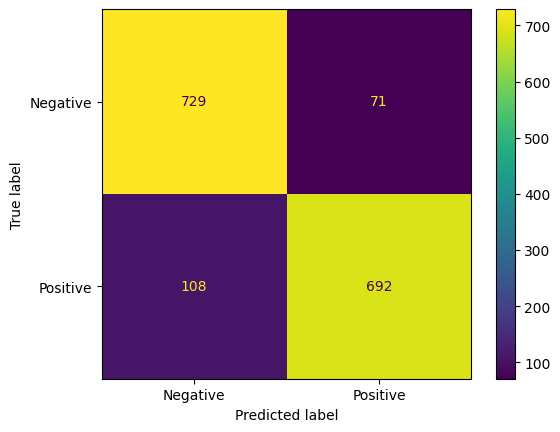

              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89       800
    Positive       0.91      0.86      0.89       800

    accuracy                           0.89      1600
   macro avg       0.89      0.89      0.89      1600
weighted avg       0.89      0.89      0.89      1600

Accuracy: 0.888125
Recall: 0.865
Precision: 0.9069462647444299
F1-score: 0.8854766474728087


In [17]:
labels = ['Negative', 'Positive']

get_model_evaluation(y_true=testing_data['Label'], y_pred=model_predictions, labels=labels)